<a href="https://colab.research.google.com/github/rashmi05pathak/CS6910_Assignment3/blob/main/CS6910_Assignment3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Experimentation for Question1***

In [1]:
import os
import numpy as np
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [2]:
# Downloading dakshina dataset
!yes | wget "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"

--2022-05-12 16:19:18--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   192MB/s    in 11s     

2022-05-12 16:19:29 (173 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [22]:
# Unzipping dataset
!yes | tar xopf dakshina_dataset_v1.0.tar

tar: dakshina_dataset_v1.0.tar: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [23]:
#!ls
#path = "/content/dakshina_dataset_v1.0/hi/lexicons"

In [24]:
#import os
#os.chdir(path)

In [25]:
os.listdir()

['hi.translit.sampled.dev.tsv',
 'hi.translit.sampled.train.tsv',
 'hi.translit.sampled.test.tsv']

In [26]:
#import os
# iterate through all file
#for file in os.listdir():
#file = os.listdir()
#f = open(file[2],"r")
#for x in f:
#    print(x)

In [21]:
import pandas as pd
train_data = pd.read_csv('/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv', sep='\t')
dev_data  =  pd.read_csv('/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv',sep='\t')
test_data =  pd.read_csv('/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv',sep='\t')

In [33]:
arr = np.asarray(train_data)

In [36]:
arr.shape

(44203, 3)

In [37]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"

In [38]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [39]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [40]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [41]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 61
Number of unique output tokens: 28
Max sequence length for inputs: 18
Max sequence length for outputs: 20


In [42]:
num_encoder_tokens

61

In [44]:
num_decoder_tokens

28

In [45]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")


In [59]:
#input_token_index

In [46]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    #encoder_input_data[i, t + 1 :, input_token_index["\t"]]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    #decoder_input_data[i, t + 1 :, target_token_index[char]] = 1.0
    #decoder_target_data[i, t:, target_token_index[char]] = 1.0

In [57]:
#encoder_input_data.shape
#decoder_input_data.shape
#decoder_target_data.shape


(10000, 20, 28)

In [48]:
num_encoder_tokens
import keras

In [49]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens-2))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens-2))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens-2, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

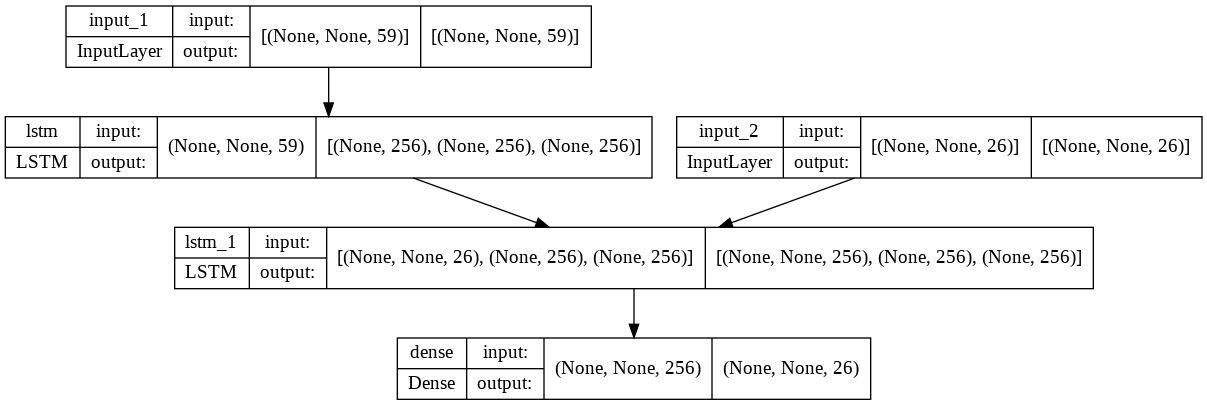

In [50]:
plot_model(model,to_file='model.png',show_shapes = True)

In [51]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [52]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=10,
    validation_split=0.1,
)

Epoch 1/10


ValueError: ignored